## Perturbation of sequences
### Dataset: SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 94 (93 + 1) 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

94

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = orig_pred_val - df[human_label]
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(2978369, 9)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.993524,0.006476,UniRef90_A0A8B6RAI1,Human,S,815,D,0.000024,0.000024
1,0.993559,0.006441,UniRef90_A0A8B6RAI1,Human,S,1029,T,-0.000011,0.000011
2,0.993511,0.006489,UniRef90_A0A8B6RAI1,Human,L,386,Y,0.000037,0.000037
3,0.993570,0.006430,UniRef90_A0A8B6RAI1,Human,R,157,T,-0.000022,0.000022
4,0.993544,0.006456,UniRef90_A0A8B6RAI1,Human,S,1195,C,0.000004,0.000004


### Distribution of prediction difference values

/tmp/ipykernel_4114053/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

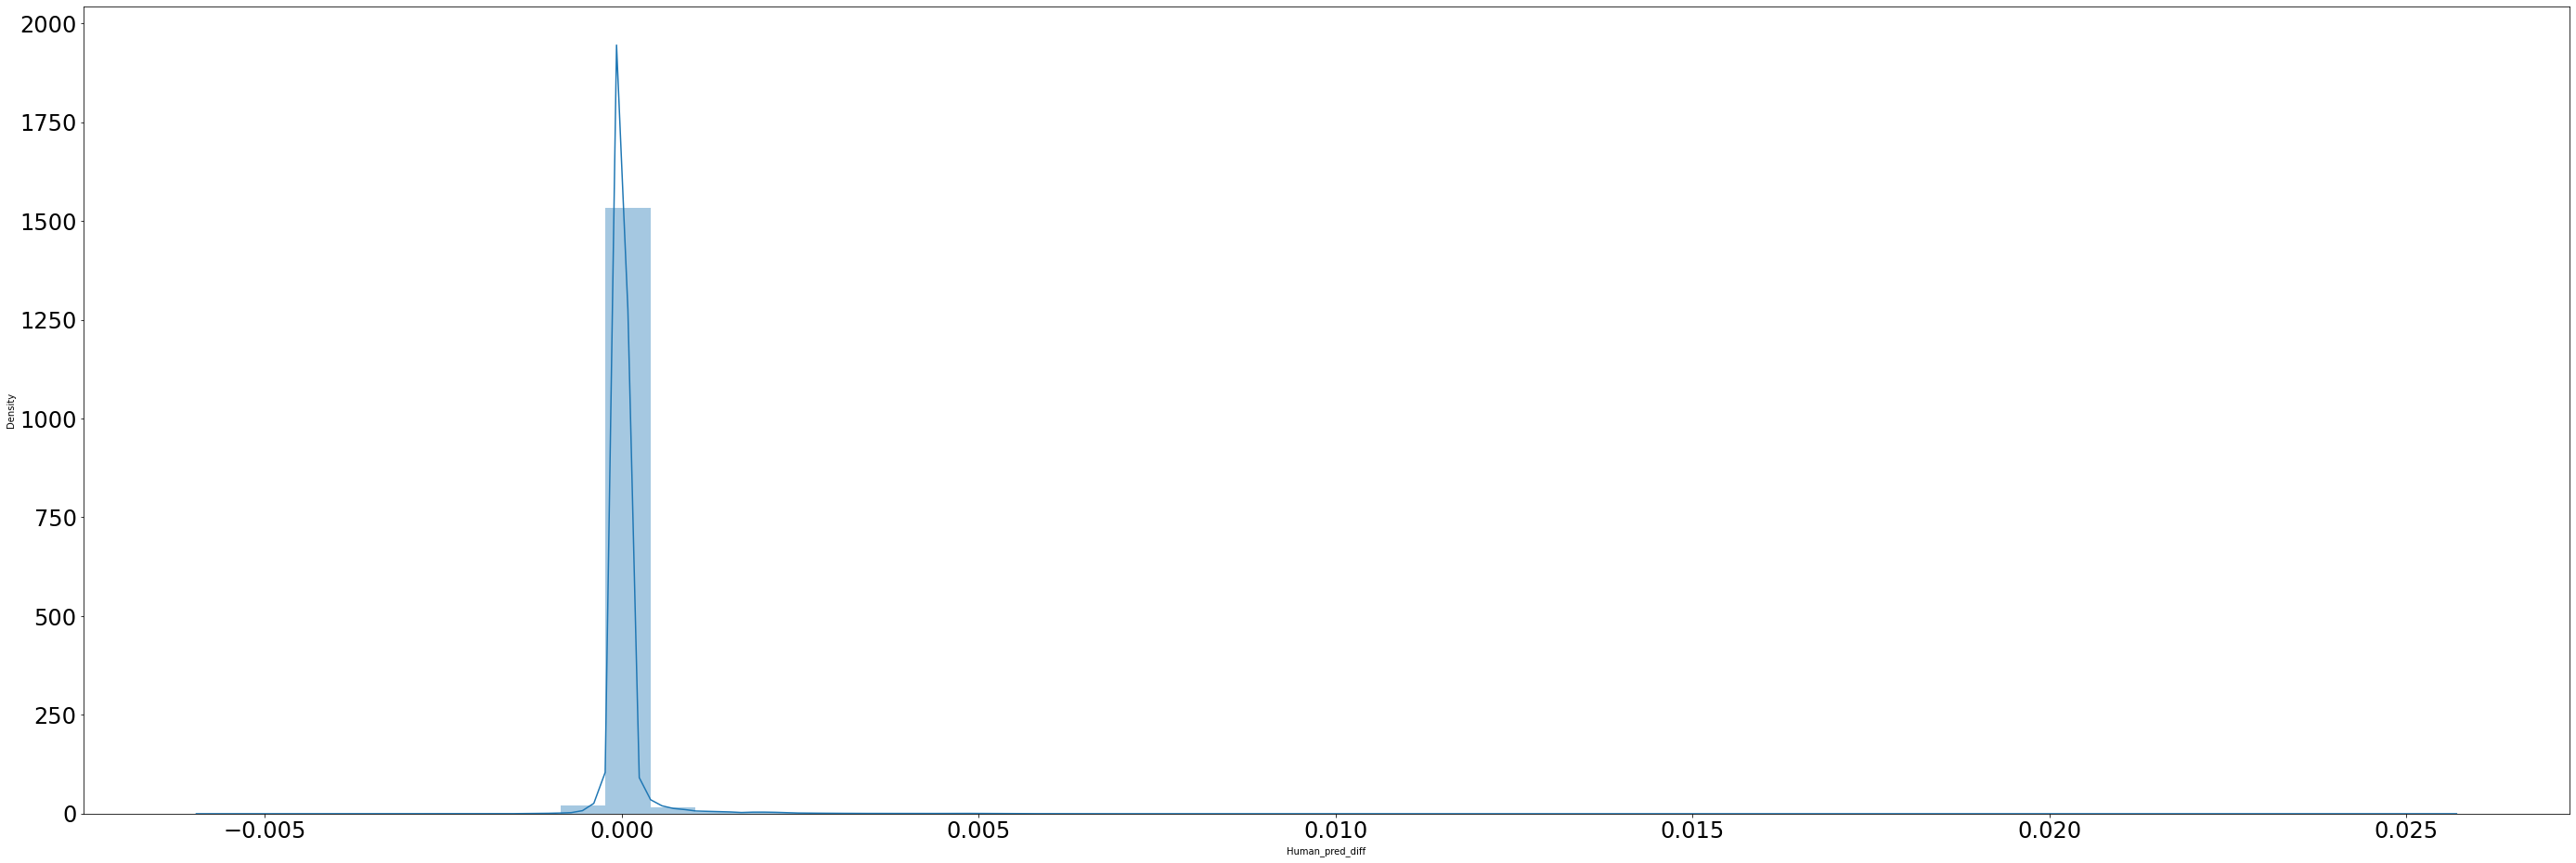

In [6]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [7]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.005910,-0.003280,142,0.004768
1,-0.003280,-0.000649,3661,0.122920
2,-0.000649,0.001982,2961216,99.424081
3,0.001982,0.004612,10155,0.340958
4,0.004612,0.007243,2461,0.082629
5,0.007243,0.009873,412,0.013833
6,0.009873,0.012504,148,0.004969
7,0.012504,0.015135,81,0.002720
8,0.015135,0.017765,28,0.000940
9,0.017765,0.020396,28,0.000940


### Top 10 perturbations with highest change in prediction probability

In [8]:
perturbed_output_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
26706,0.964997,0.035003,UniRef90_A0A8B6RK62,Human,X,270,W,0.025657,0.025657
16704,0.965518,0.034482,UniRef90_A0A8B6RKY6,Human,X,270,W,0.025197,0.025197
29595,0.966324,0.033676,UniRef90_A0A8B6RK62,Human,S,160,W,0.024330,0.024330
29867,0.964220,0.035780,UniRef90_A0A8B6RKC6,Human,S,160,W,0.024223,0.024223
142,0.966823,0.033177,UniRef90_A0A8B6RKY6,Human,S,160,W,0.023892,0.023892
27598,0.966849,0.033151,UniRef90_A0A8B6RK62,Human,X,198,W,0.023805,0.023805
15651,0.964777,0.035223,UniRef90_A0A8B6RKC6,Human,X,270,W,0.023667,0.023667
17067,0.967364,0.032636,UniRef90_A0A8B6RKY6,Human,X,198,W,0.023351,0.023351
26888,0.967357,0.032643,UniRef90_A0A8B6RK62,Human,X,197,W,0.023297,0.023297
9730,0.967840,0.032160,UniRef90_A0A8B6RKY6,Human,X,197,W,0.022875,0.022875


In [9]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['perturb_pos']}_{x['new_token']}", axis=1)
perturbed_output_df.head()

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturbation_id
0,0.993524,0.006476,UniRef90_A0A8B6RAI1,Human,S,815,D,0.000024,0.000024,815_D
1,0.993559,0.006441,UniRef90_A0A8B6RAI1,Human,S,1029,T,-0.000011,0.000011,1029_T
2,0.993511,0.006489,UniRef90_A0A8B6RAI1,Human,L,386,Y,0.000037,0.000037,386_Y
3,0.993570,0.006430,UniRef90_A0A8B6RAI1,Human,R,157,T,-0.000022,0.000022,157_T
4,0.993544,0.006456,UniRef90_A0A8B6RAI1,Human,S,1195,C,0.000004,0.000004,1195_C


In [10]:
mean_diff_df = perturbed_output_df[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [11]:
mean_diff_df = mean_diff_df.reset_index()

In [12]:
mean_diff_df[["perturb_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [13]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_pos,new_token
0,0_A,0.000657,0,A
1,0_B,0.000613,0,B
2,0_C,0.000875,0,C
3,0_D,0.000534,0,D
4,0_E,0.000392,0,E


In [14]:
mean_diff_df[mean_diff_df[["perturb_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_pos,new_token


In [15]:
df = mean_diff_df.pivot(columns="perturb_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [16]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_pos,new_token
1086,1038_L,0.008882,1038,L
11888,270_W,0.005455,270,W
9787,198_W,0.005019,198,W
1088,1038_N,0.005002,1038,N
8724,160_W,0.004961,160,W
1078,1038_D,0.004915,1038,D
9761,197_W,0.004906,197,W
1082,1038_H,0.004864,1038,H
1090,1038_P,0.004854,1038,P
11914,271_W,0.004848,271,W


<Figure size 432x288 with 0 Axes>

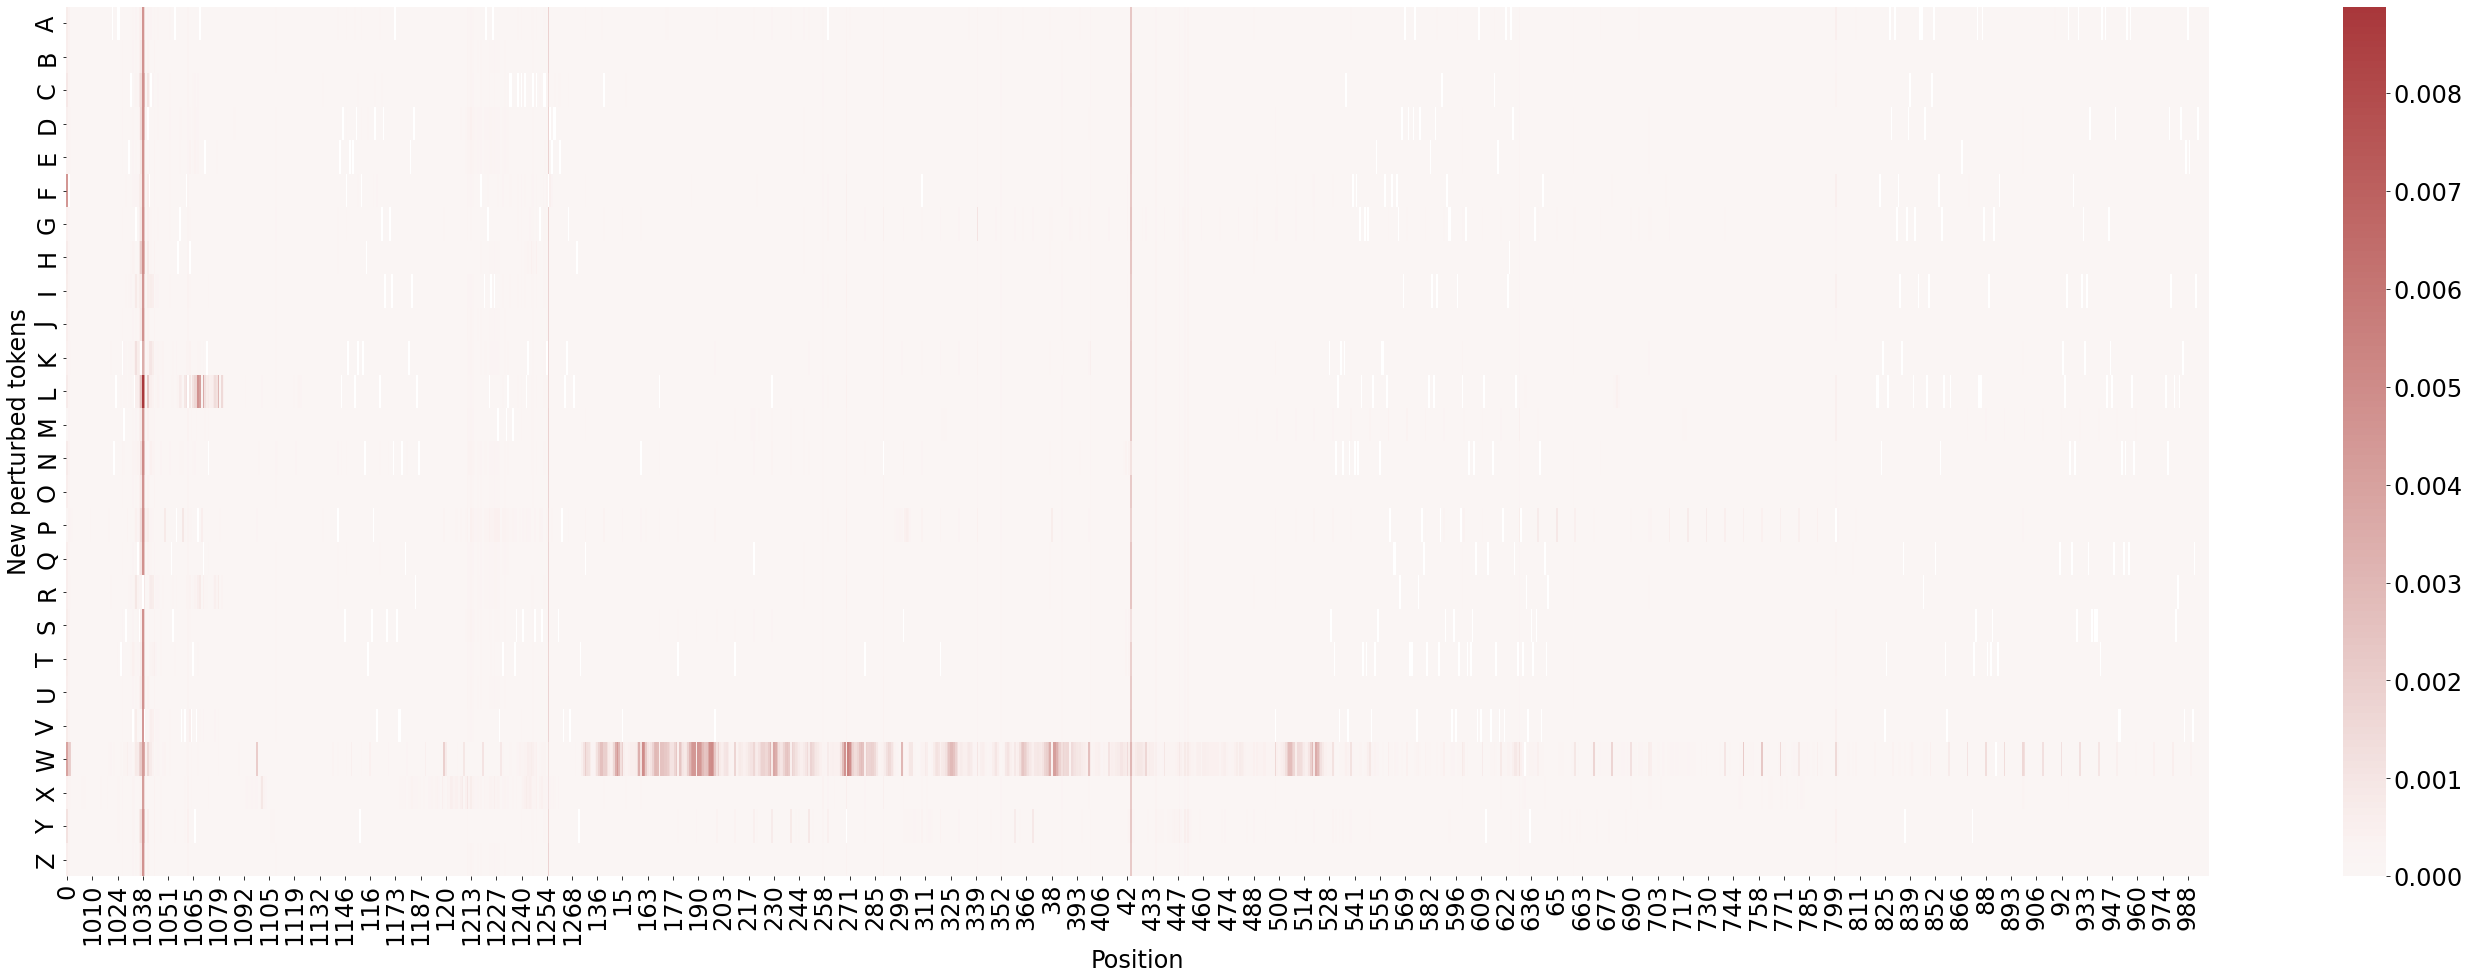

In [17]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [18]:
df.mean(axis=0)

perturb_pos
0       0.000870
1       0.000389
10      0.000170
100     0.000043
1000    0.000037
          ...   
995     0.000026
996     0.000019
997     0.000021
998     0.000033
999     0.000028
Length: 1273, dtype: float64

<Figure size 432x288 with 0 Axes>

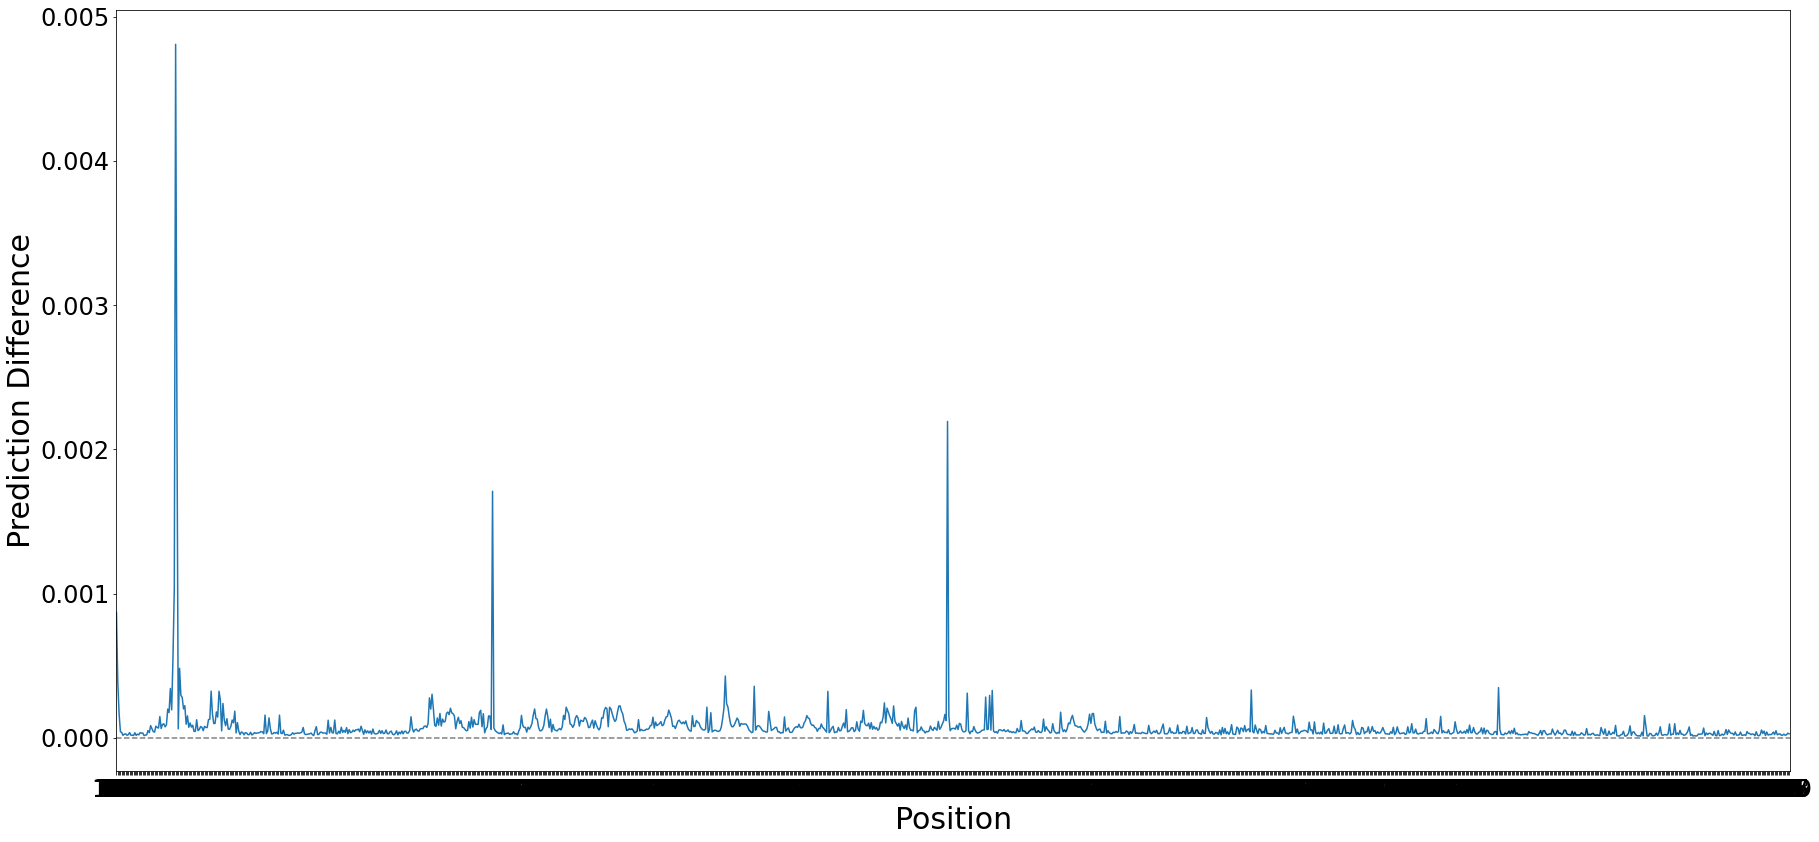

In [19]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
ax.set_xlim(0, 1273)
plt.show()